<p style="padding: 10px; border: 1px solid black;">
<img src="images/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>


# <a name="0">MLU LangChain Workshop </a>
## <a name="0">Lab 3: Retrival Augmented Generation (RAG) </a>

In this notebook, we will apply Retrieval Augmented Generation (RAG) to adapt an LLM to a specific task. Many applications require task-specific data which may not be a part of the LLM's training data. Additionally, relevant context may undergo contant changes or fluctuations such as weather, stock prices and so on. RAG involves retrieving data from relevant and reliable sources and augmenting the context of the prompt, in order to generate the desired response. LangChain provides several modules to implement a RAG worksflow.

1. <a href="#1">Import libraries</a>
2. <a href="#2">Document Loaders</a>
    - <a href="#2.1">URL Loader</a>
    - <a href="#2.2">PDF Loader</a>
    - <a href="#2.3">Wikipedia Loader</a>
3. <a href="#3">Document Splitters</a>
4. <a href="#4">Vector Stores</a>
5. <a href="#5">Define the Bedrock Model for Inference</a>
6. <a href="#6">Retrieval Q&A</a>
7. <a href="#7">Conversational Q&A</a>
8. <a href="#8">Quizzes</a>
    
    
Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="./images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="./images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you test your understanding by taking a short quiz.</p> |

----    


Let's start by loading some libraries and packages!

---

### <a name="1">Import libraries</a>
(<a href="#0">Go to top</a>)


First, let's install and import the necessary libraries, including the Hugging Face Transformers library and the PyTorch library, which is a dependency for Transformers.


In [1]:
%%capture
!pip3 install -r requirements.txt --quiet

In [2]:
import boto3
import json

import warnings
from IPython.display import Markdown
import re
import random
import pandas as pd

warnings.filterwarnings("ignore")

### <a name="#2">Document Loaders</a>
(<a href="#0">Go to top</a>)

Document loaders are used to load data from external sources as `Documents`. A `Document` is a piece of text and associated metadata.
Langchain offers a number of other document loaders and [integrations](https://python.langchain.com/docs/integrations/document_loaders/). Some of note:

- S3FileLoader
- S3DirectoryLoader
- AmazonTextractPDFLoader
- CSVLoader

---

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Try different document loaders and different prompts for the retrieval chains in the notebook.</p>
    <p style=" text-align: center; margin: auto;"><b>Note: Results may not be factually accurate and may be based on false assumptions.</b></p>
    <br>
</div>

#### <a name="2.1">URL Loader</a>
(<a href="#0">Go to top</a>)

For this notebook we will load an [AWS blogpost](https://aws.amazon.com/blogs/machine-learning/quickly-build-high-accuracy-generative-ai-applications-on-enterprise-data-using-amazon-kendra-langchain-and-large-language-models/) on Retrieval Augmented Generation as the external source.

- Preprocessing the data is by the most important thing you can spend your time on.
- Models are sensitive to newlines. Err on the side of deleting them.

In [3]:
from langchain.document_loaders import UnstructuredURLLoader

# List of URLs for the loader. We will only use one in this example.
urls = [
    "https://aws.amazon.com/blogs/machine-learning/quickly-build-high-accuracy-generative-ai-applications-on-enterprise-data-using-amazon-kendra-langchain-and-large-language-models/",
]

# Define the URL Loader
loader = UnstructuredURLLoader(urls=urls)

# Load the data
data = loader.load()

# Pre-process the content a bit
data[0].page_content = re.sub("\n{3,}", "\n", data[0].page_content)
data[0].page_content = re.sub(" {2,}", " ", data[0].page_content)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
Markdown(data[0].page_content)

AWS Machine Learning Blog

Quickly build high-accuracy Generative AI applications on enterprise data using Amazon Kendra, LangChain, and large language models

Abhinav Jawadekar,

Abhishek Maligehalli Shivalingaiah,

Firaz Akmal,

Jean-Pierre Dodel, and

Mithil Shah | on

Amazon Kendra, Artificial Intelligence, Generative AI |

Permalink |

Comments |

Share
June 2023: This post was updated to cover the Amazon Kendra Retrieve API optimized for RAG use cases, and Amazon Kendra retriever now being part of the LangChain GitHub repo. This revision also updates the instructions to use new version samples from the AWS Samples GitHub repo.

Generative AI (GenAI) and large language models (LLMs), such as those available soon via Amazon Bedrock and Amazon Titan are transforming the way developers and enterprises are able to solve traditionally complex challenges related to natural language processing and understanding. Some of the benefits offered by LLMs include the ability to create more capable and compelling conversational AI experiences for customer service applications, and improving employee productivity through more intuitive and accurate responses.

For these use cases, however, it’s critical for the GenAI applications implementing the conversational experiences to meet two key criteria: limit the responses to company data, thereby mitigating model hallucinations (incorrect statements), and filter responses according to the end-user content access permissions.

To restrict the GenAI application responses to company data only, we need to use a technique called Retrieval Augmented Generation (RAG). An application using the RAG approach retrieves information most relevant to the user’s request from the enterprise knowledge base or content, bundles it as context along with the user’s request as a prompt, and then sends it to the LLM to get a GenAI response. LLMs have limitations around the maximum word count for the input prompt, therefore choosing the right passages among thousands or millions of documents in the enterprise, has a direct impact on the LLM’s accuracy.

intelligent search in

Amazon Kendra plays an important role. Amazon Kendra is a fully managed service that provides out-of-the-box semantic search capabilities for state-of-the-art ranking of documents and passages. You can use the high-accuracy search in Amazon Kendra to source the most relevant content and documents to maximize the quality of your RAG payload, yielding better LLM responses than using conventional or keyword-based search solutions. Amazon Kendra offers easy-to-use deep learning search models that are pre-trained on 14 domains and don’t require any ML expertise, so there’s no need to deal with word embeddings, document chunking, and other lower-level complexities typically required for RAG implementations. Amazon Kendra provides the

Retrieve API, designed for the RAG use case. With the Retrieve API, you can retrieve up to 100 semantically relevant passages of up to 200 token words each, ordered by relevance. Amazon Kendra also comes with pre-built connectors to popular data sources such as

Amazon Simple Storage Service (Amazon S3), SharePoint, Confluence, and websites, and supports common document formats such as HTML, Word, PowerPoint, PDF, Excel, and pure text files. To filter responses based on only those documents that the end-user permissions allow, Amazon Kendra offers connectors with access control list (ACL) support. Amazon Kendra also offers

AWS Identity and Access Management (IAM) and

AWS IAM Identity Center (successor to AWS Single Sign-On) integration for user-group information syncing with customer identity providers such as Okta and Azure AD.

In this post, we demonstrate how to implement a RAG workflow by combining the capabilities of Amazon Kendra with LLMs to create state-of-the-art GenAI applications providing conversational experiences over your enterprise content. After Amazon Bedrock launches, we will publish a follow-up post showing how to implement similar GenAI applications using Amazon Bedrock, so stay tuned.

Solution overview

The following diagram shows the architecture of a GenAI application with a RAG approach.

We use an Amazon Kendra index to ingest enterprise unstructured data from data sources such as wiki pages, MS SharePoint sites, Atlassian Confluence, and document repositories such as Amazon S3. When a user interacts with the GenAI app, the flow is as follows:

The user makes a request to the GenAI app.

The app issues a search query to the Amazon Kendra index based on the user request.

The index returns search results with excerpts of relevant documents from the ingested enterprise data.

The app sends the user request and along with the data retrieved from the index as context in the LLM prompt.

The LLM returns a succinct response to the user request based on the retrieved data.

The response from the LLM is sent back to the user.

With this architecture, you can choose the most suitable LLM for your use case. LLM options include our partners Hugging Face, AI21 Labs, Cohere, and others hosted on an Amazon SageMaker endpoint, as well as models by companies like Anthropic and OpenAI. With Amazon Bedrock, you will be able to choose Amazon Titan, Amazon’s own LLM, or partner LLMs such as those from AI21 Labs and Anthropic with APIs securely without the need for your data to leave the AWS ecosystem. The additional benefits that Amazon Bedrock will offer include a serverless architecture, a single API to call the supported LLMs, and a managed service to streamline the developer workflow.

LangChain that provide modules to integrate with the LLM of choice, and orchestration tools for activities such as chat history management and prompt engineering. We have provided the

AmazonKendraRetriever

LangChain retriever interface, which applications can use in conjunction with other LangChain interfaces such as

chains to retrieve data from an Amazon Kendra index.

GitHub repo. You can deploy this solution in your AWS account using the step-by-step guide in this post.

Prerequisites

For this tutorial, you’ll need a bash terminal with Python 3.9 or higher installed on Linux, Mac, or Windows Subsystem for Linux, and an AWS account. We also recommend using an AWS Cloud9 instance or an Amazon Elastic Compute Cloud (Amazon EC2) instance.

Implement a RAG workflow

To configure your RAG workflow, complete the following steps:

Use the provided AWS CloudFormation template to create a new Amazon Kendra index.

This template includes sample data containing AWS online documentation for Amazon Kendra, Amazon Lex, and Amazon SageMaker. Alternately, if you have an Amazon Kendra index and have indexed your own dataset, you can use that. Launching the stack requires about 30 minutes followed by about 15 minutes to synchronize it and ingest the data in the index. Therefore, wait for about 45 minutes after launching the stack. Note the index ID and AWS Region on the stack’s Outputs tab.

The sample applications used in this tutorial require you to have access to one or more LLMs from Flan-T5-XL, Flan-T5-XXL, Anthropic Claud-V1, and OpenAI-text-davinci-003. 
 
 If you want to use Flan-T5-XL or Flan-T5-XXL, deploy them to an endpoint for inference using Amazon SageMaker Studio Jumpstart. 
 If you want to work with Anthropic Claud-V1 or OpenAI-da-vinci-003, acquire the API keys for your LLMs of your interest from https://www.anthropic.com/ and https://openai.com/, respectively.

Follow the instructions in the GitHub repo to install the prerequisites, including LangChain, and sample applications.

Before you run the sample applications, you need to set environment variables with the Amazon Kendra index details and API keys of your preferred LLM or the SageMaker endpoints of your deployments for Flan-T5-XL or Flan-T5-XXL. The following is a sample script to set the environment variables (Note that it will suffice to have only one of FLAN_XL_ENDPOINT, FLAN_XXL_ENDPOINT, OPENAI_API_KEY or ANTHROPIC_API_KEY to try out the samples, as long as you only use the corresponding sample): 
 
 export AWS_REGION="<YOUR-AWS-REGION>"
export KENDRA_INDEX_ID="<YOUR-KENDRA-INDEX-ID>"
export FLAN_XL_ENDPOINT="<YOUR-SAGEMAKER-ENDPOINT-FOR-FLAN-T-XL>"
export FLAN_XXL_ENDPOINT="<YOUR-SAGEMAKER-ENDPOINT-FOR-FLAN-T-XXL>"
export OPENAI_API_KEY="<YOUR-OPEN-AI-API-KEY>"
export ANTHROPIC_API_KEY="<YOUR-ANTHROPIC-API-KEY>"

In a command line window, change to the kendra_retriever_samples subdirectory of where you have cloned the GitHub repository. You can run the command line apps from the command line as python <sample-file-name.py>. Run the streamlit web app by changing the directory to samples and running streamlit run app.py <anthropic|flanxl|flanxxl|openai>.

Open the sample file kendra_retriever_flan_xxl.py in an editor of your choice.

Observe the statement result = run_chain(chain, "What's SageMaker?"). This is the user query (“What’s SageMaker?”) that’s being run through the chain that uses Flan-T-XXL as the LLM and Amazon Kendra as the retriever. When this file is run, you can observe the output as follows. The chain sent the user query to the Amazon Kendra index, retrieved the top three result excerpts, and sent them as the context in a prompt along with the query, to which the LLM responded with a succinct answer. It has also provided the sources, (the URLs to the documents used in generating the answer).

https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-intro.html

https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-projects-whatis.html

https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html

Now let’s run the web app app.py as streamlit run app.py flanxxl. For this specific run, we are using a Flan-T-XXL model as the LLM.

It opens a browser window with the web interface. You can enter a query, which in this case is “What is Amazon Lex?” As seen in the following screenshot, the application responds with an answer, and the Sources section provides the URLs to the documents from which the excerpts were retrieved from the Amazon Kendra index and sent to the LLM in the prompt as the context along with the query.

Now let’s run app.py again and get a feel of the conversational experience using streamlit run app.py anthropic. Here the underlying LLM used is Anthropic Claud-V1.

As you can see in the following video, the LLM provides a detailed answer to the user’s query based on the documents it retrieved from the Amazon Kendra index and then supports the answer with the URLs to the source documents that were used to generate the answer. Note that the subsequent queries don’t explicitly mention Amazon Kendra; however, the ConversationalRetrievalChain (a type of chain that’s part of the LangChain framework and provides an easy mechanism to develop conversational application-based information retrieved from retriever instances, used in this LangChain application), manages the chat history and the context to get an appropriate response.

Also note that in the following screenshot, Amazon Kendra finds the extractive answer to the query and shortlists the top documents with excerpts. Then the LLM is able to generate a more succinct answer based on these retrieved excerpts.

In the following sections, we explore two use cases for using Generative AI with Amazon Kendra.

Use case 1: Generative AI for financial service companies

Financial organizations create and store data across various data repositories, including financial reports, legal documents, and whitepapers. They must adhere to strict government regulations and oversight, which means employees need to find relevant, accurate, and trustworthy information quickly. Additionally, searching and aggregating insights across various data sources is cumbersome and error prone. With Generative AI on AWS, users can quickly generate answers from various data sources and types, synthesizing accurate answers at enterprise scale.

We chose a solution using Amazon Kendra and AI21 Lab’s Jurassic-2 Jumbo Instruct LLM. With Amazon Kendra, you can easily ingest data from multiple data sources such as Amazon S3, websites, and ServiceNow. Then Amazon Kendra uses AI21 Lab’s Jurassic-2 Jumbo Instruct LLM to carry out inference activities on enterprise data such as data summarization, report generation, and more. Amazon Kendra augments LLMs to provide accurate and verifiable information to the end-users, which reduces hallucination issues with LLMs. With the proposed solution, financial analysts can make faster decisions using accurate data to quickly build detailed and comprehensive portfolios. We plan to make this solution available as an open-source project in near future.

Example

Using the Kendra Chatbot solution, financial analysts and auditors can interact with their enterprise data (financial reports and agreements) to find reliable answers to audit-related questions. Kendra ChatBot provides answers along with source links and has the capability to summarize longer answers. The following screenshot shows an example conversation with Kendra ChatBot.

Architecture overview

The following diagram illustrates the solution architecture.

The workflow includes the following steps:

Financial documents and agreements are stored on Amazon S3, and ingested to an Amazon Kendra index using the S3 data source connector.

The LLM is hosted on a SageMaker endpoint.

An Amazon Lex chatbot is used to interact with the user via the Amazon Lex web UI.

The solution uses an AWS Lambda function with LangChain to orchestrate between Amazon Kendra, Amazon Lex, and the LLM.

When users ask the Amazon Lex chatbot for answers from a financial document, Amazon Lex calls the LangChain orchestrator to fulfill the request.

Based on the query, the LangChain orchestrator pulls the relevant financial records and paragraphs from Amazon Kendra.

The LangChain orchestrator provides these relevant records to the LLM along with the query and relevant prompt to carry out the required activity.

The LLM processes the request from the LangChain orchestrator and returns the result.

The LangChain orchestrator gets the result from the LLM and sends it to the end-user through the Amazon Lex chatbot.

Use case 2: Generative AI for healthcare researchers and clinicians

Clinicians and researchers often analyze thousands of articles from medical journals or government health websites as part of their research. More importantly, they want trustworthy data sources they can use to validate and substantiate their findings. The process requires hours of intensive research, analysis, and data synthesis, lengthening the time to value and innovation. With Generative AI on AWS, you can connect to trusted data sources and run natural language queries to generate insights across these trusted data sources in seconds. You can also review the sources used to generate the response and validate its accuracy.

We chose a solution using Amazon Kendra and Flan-T5-XXL from Hugging Face. First, we use Amazon Kendra to identify text snippets from semantically relevant documents in the entire corpus. Then we use the power of an LLM such as Flan-T5-XXL to use the text snippets from Amazon Kendra as context and obtain a succinct natural language answer. In this approach, the Amazon Kendra index functions as the passage retriever component in the RAG mechanism. Lastly, we use Amazon Lex to power the front end, providing a seamless and responsive experience to end-users. We plan to make this solution available as an open-source project in the near future.

Example

The following screenshot is from a web UI built for the solution using the template available on GitHub. The text in pink are responses from the Amazon Kendra LLM system, and the text in blue are the user questions.

Architecture overview

The architecture and solution workflow for this solution are similar to that of use case 1.

Clean up

To save costs, delete all the resources you deployed as part of the tutorial. If you launched the CloudFormation stack, you can delete it via the AWS CloudFormation console. Similarly, you can delete any SageMaker endpoints you may have created via the SageMaker console.

Conclusion

Generative AI powered by large language models is changing how people acquire and apply insights from information. However, for enterprise use cases, the insights must be generated based on enterprise content to keep the answers in-domain and mitigate hallucinations, using the Retrieval Augmented Generation approach. In the RAG approach, the quality of the insights generated by the LLM depends on the semantic relevance of the retrieved information on which it is based, making it increasingly necessary to use solutions such as Amazon Kendra that provide high-accuracy semantic search results out of the box. With its Retrieve API (designed specifically for RAG), comprehensive ecosystem of data source connectors, support for common file formats, and security, you can quickly start using Generative AI solutions for enterprise use cases with Amazon Kendra as the retrieval mechanism.

For more information on working with Generative AI on AWS, refer to Announcing New Tools for Building with Generative AI on AWS. You can start experimenting and building RAG proofs of concept (POCs) for your enterprise GenAI apps, using the method outlined in this blog. As mentioned earlier, once Amazon Bedrock is available, we will publish a follow up blog showing how you can build RAG using Amazon Bedrock.

About the authors

Abhinav Jawadekar is a Principal Solutions Architect focused on Amazon Kendra in the AI/ML language services team at AWS. Abhinav works with AWS customers and partners to help them build intelligent search solutions on AWS.

Jean-Pierre Dodel is the Principal Product Manager for Amazon Kendra and leads key strategic product capabilities and roadmap prioritization. He brings extensive Enterprise Search and ML/AI experience to the team, with prior leading roles at Autonomy, HP, and search startups prior to joining Amazon 7 years ago.

Mithil Shah is an ML/AI Specialist at AWS. Currently he helps public sector customers improve lives of citizens by building Machine Learning solutions on AWS.

Firaz Akmal is a Sr. Product Manager for Amazon Kendra at AWS. He is a customer advocate, helping customers understand their search and generative AI use-cases with Kendra on AWS. Outside of work Firaz enjoys spending time in the mountains of the PNW or experiencing the world through his daughter’s perspective.

Abhishek Maligehalli Shivalingaiah is a Senior AI Services Solution Architect at AWS with focus on Amazon Kendra. He is passionate about building applications using Amazon Kendra ,Generative AI and NLP. He has around 10 years of experience in building Data & AI solutions to create value for customers and enterprises. He has built a (personal) chatbot for fun to answers questions about his career and professional journey. Outside of work he enjoys making portraits of family & friends, and loves creating artworks.

Comments

View Comments

#### <a name="2.2">PDF Loader</a>
(<a href="#0">Go to top</a>)

Needs pypdf to function. (!pip install pypdf)

In [5]:
from langchain.document_loaders import PyPDFLoader

# Define the PDF loader
pdf_loader = PyPDFLoader("data/d2l-textbook.pdf")

# Load data from the pdf
pages = pdf_loader.load()

# Observe number of pages loaded
print("Number of pages loaded: {} \n".format(len(pages)))

# Print contents of the 90th page
Markdown(pages[90].page_content)

Number of pages loaded: 1197 



49 Linear Algebra
denotedbyavector x2Rnandasetofweightsdenotedby w2Rn,theweightedsumofthe
values in xaccording to the weights wcould be expressed as the dot product x⊤w. When
theweightsarenon-negativeandsumtoone,i.e., (∑n
i=1wi= 1),thedotproductexpressesa
weightedaverage .Afternormalizingtwovectorstohaveunitlength,thedotproductsexpress
the cosine of the angle between them. Later in this section, we will formally introduce this
notionof length.
2.3.9Matrix-VectorProducts
Now that we know how to calculate dot products, we can begin to understand the product
between an mnmatrix Aand an n-dimensional vector x. To start oﬀ, we visualize our
matrixintermsofitsrowvectors
A=266666664a⊤
1
a⊤
2:::
a⊤
m377777775; (2.3.5)
whereeach a⊤
i2Rnisarowvectorrepresentingthe ithrowofthematrix A.
Thematrix-vectorproduct Axissimplyacolumnvectoroflength m,whose ithelementis
thedotproduct a⊤
ix:
Ax=266666664a⊤
1
a⊤
2:::
a⊤
m377777775x=266666664a⊤
1x
a⊤
2x
:::
a⊤
mx377777775: (2.3.6)
We can think of multiplication with a matrix A2Rmnas a transformation that projects
vectorsfrom RntoRm.Thesetransformationsareremarkablyuseful.Forexample,wecan
representrotationsasmultiplicationsbycertainsquarematrices.Matrix-vectorproductsalso
describethekeycalculationinvolvedincomputingtheoutputsofeachlayerinaneuralnet-
workgiventheoutputsfromthepreviouslayer.
To express a matrix-vector product in code, we use the mvfunction. Note that the column
dimensionof A(itslengthalongaxis1)mustbethesameasthedimensionof x(itslength).
PyTorchhasaconvenienceoperator @thatcanexecutebothmatrix-vectorandmatrix-matrix
products(dependingonitsarguments).Thuswecanwrite A@x.
A.shape, x .shape, torch .mv(A, x), A @x
(torch .Size([ 2,3]), torch .Size([ 3]), tensor([ 5.,14.]), tensor([ 5.,14.]))
2.3.10Matrix-MatrixMultiplication

#### <a name="2.3">Wikipedia Loader</a>
(<a href="#0">Go to top</a>)

Need to install wikipedia (!pip install wikipedia)

In [6]:
from langchain.document_loaders import WikipediaLoader

# Define the Wikipedia Loader
wiki_loader = WikipediaLoader(query="Sagemaker", load_max_docs=1)

# Load pages from Wikipedia based on the query
wiki_doc = wiki_loader.load()

# Observe the retrieved page
Markdown(wiki_doc[0].page_content)

Amazon SageMaker is a cloud-based machine-learning platform that allows the creation, training, and deployment by developers of machine-learning (ML) models on the cloud. It can be used to deploy ML models on embedded systems and edge-devices. The platform was launched in November 2017.


== Capabilities ==
SageMaker enables developers to operate at a number of different levels of abstraction when training and deploying machine learning models. At its highest level of abstraction, SageMaker provides pre-trained ML models that can be deployed as-is. In addition, it offers a number of built-in ML algorithms that developers can train on their own data. 
The platform also features managed instances of TensorFlow and Apache MXNet, where developers can create their own ML algorithms from scratch. Regardless of which level of abstraction is used, a developer can connect their SageMaker-enabled ML models to other AWS services, such as the Amazon DynamoDB database for structured data storage, AWS Batch for offline batch processing, or Amazon Kinesis for real-time processing.


== Development interfaces ==
A number of interfaces are available for developers to interact with SageMaker. First, there is a web API that remotely controls a SageMaker server instance. While the web API is agnostic to the programming language used by the developer, Amazon provides SageMaker API bindings for a number of languages, including Python, JavaScript, Ruby, Java, and Go. In addition, SageMaker provides managed Jupyter Notebook instances for interactively programming SageMaker and other applications.


== History and features ==
2017-11-29: SageMaker is launched at the AWS re:Invent conference.
2018-02-27: Managed TensorFlow and MXNet deep neural network training and inference are now supported within SageMaker.
2018-02-28: SageMaker automatically scales model inference to multiple server instances.
2018-07-13: Support is added for recurrent neural network training, word2vec training, multi-class linear learner training, and distributed deep neural network training in Chainer with Layer-wise Adaptive Rate Scaling (LARS).
2018-07-17: AWS Batch Transform enables high-throughput non-real-time machine learning inference in SageMaker.
2018-11-08: Support for training and inference of Object2Vec word embeddings.
2018-11-27: SageMaker Ground Truth "makes it much easier for developers to label their data using human annotators through Mechanical Turk, third-party vendors, or their own employees."
2018-11-28: SageMaker Reinforcement Learning (RL) "enables developers and data scientists to quickly and easily develop reinforcement learning models at scale."
2018-11-28: SageMaker Neo enables deep neural network models to be deployed from SageMaker to edge-devices such as smartphones and smart cameras.
2018-11-29: The AWS Marketplace for SageMaker is launched. The AWS Marketplace enables 3rd-party developers to buy and sell machine learning models that can be trained and deployed in SageMaker.
2019-01-27: SageMaker Neo is released as open-source software.


== Notable Customers ==
NASCAR is using SageMaker to train deep neural networks on 70 years of video data.
Carsales.com uses SageMaker to train and deploy machine learning models to analyze and approve automotive classified ad listings.
Avis Budget Group and Slalom Consulting are using SageMaker to develop "a practical on-site solution that could address the over and under utilization of cars in real-time using an optimization engine built in Amazon SageMaker."
Volkswagen Group uses SageMaker to develop and deploy machine learning in its manufacturing plants.
Peak and Footasylum use SageMaker in a recommendation engine for footwear.


== Awards ==
In 2019, CIOL named SageMaker one of the "5 Best Machine Learning Platforms For Developers," alongside IBM Watson, Microsoft Azure Machine Learning, Apache PredictionIO, and AiONE.


== See also ==
Amazon Web Services
Amazon Lex
Amazon Polly
Amazon Rekognition
Amazon Mec

### <a name="#4">Document Splitters</a>
(<a href="#0">Go to top</a>)

Large documents may pose a challenge for RAG as they might not fit into the context window. Document splitting is often performed to split large documents into smaller chunks. This also allows the retriever to select the more relevant chunks from the document instead of feeding the entire data to an LLM. LangChain offers several modules for effectively splitting documents. In this section, we will use the `RecursiveCharacterTextSplitter`, which is also the default text splitter. 
`RecursiveTextSplitter` takes a list of separators, splits based on the first separator and moved to the next one if the chunk size is still too large.

<div>
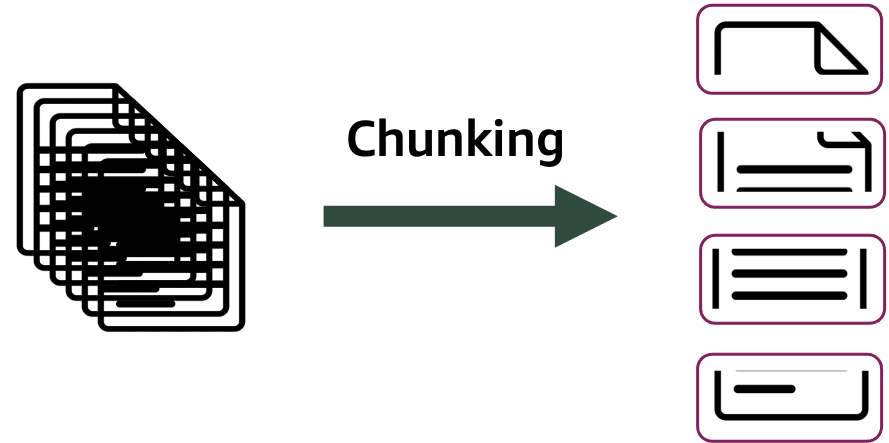
</div>

A practical idea is to chunk small but fetch large (or an entire doc). Langchain's [ParentDocumentRetriever](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever) allows you to do that. This depends also on how big the context window of your LLM is.

In [7]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
)

# Use the recursive character splitter
recur_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=60,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
    is_separator_regex=True,
)

# Perform the splits using the splitter
data_splits = recur_splitter.split_documents(data)

# Print a random chunk
print(random.choice(data_splits).page_content)

Clean up

To save costs, delete all the resources you deployed as part of the tutorial. If you launched the CloudFormation stack, you can delete it via the AWS CloudFormation console. Similarly, you can delete any SageMaker endpoints you may have created via the SageMaker console.

Conclusion

Generative AI powered by large language models is changing how people acquire and apply insights from information. However, for enterprise use cases, the insights must be generated based on enterprise content to keep the answers in-domain and mitigate hallucinations, using the Retrieval Augmented Generation approach. In the RAG approach, the quality of the insights generated by the LLM depends on the semantic relevance of the retrieved information on which it is based, making it increasingly necessary to use solutions such as Amazon Kendra that provide high-accuracy semantic search results out of the box. With its Retrieve API (designed specifically for RAG), comprehensive ecosystem of data sourc

### <a name="#4">Vector Stores</a>
(<a href="#0">Go to top</a>)

Since the split chunks need to be retrieved based on semantic relevance, using embeddings serves better than storing the chunks as text. At query time, the query is tranformed into an embeddings and used to find other similar chunk embeddings to retrieve similar chunks. 
To store these embeddings for search and retrieval, we use vector stores. In this notebook, we will use `Chroma` vector database, which is a lightweight vector db than can be run locally. Along with the embeddings, vector databases also store the corresponding text of each chunk.

<div>
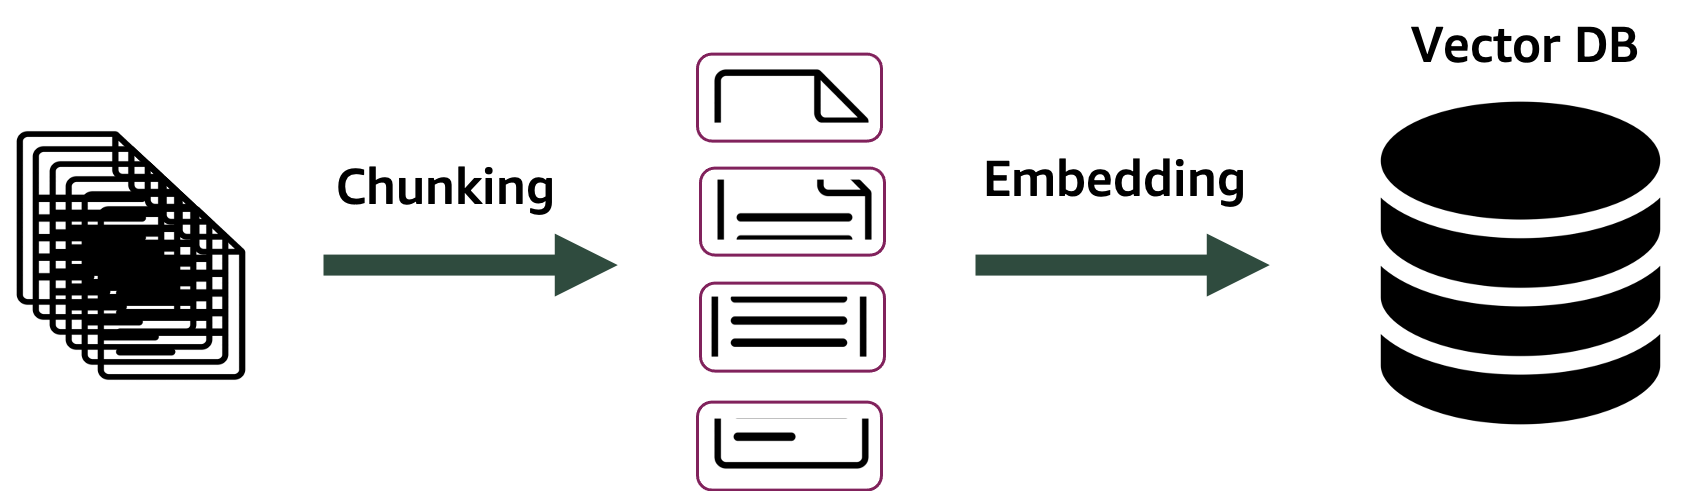
</div>

#### Embedding Model

An embedding model is required to transform the text into vectors represented using embeddings. 
We will be using the Amazon Titan Model to vectorize the chunks.

In [8]:
from langchain.embeddings import BedrockEmbeddings

# Define the bedrock client
bedrock = boto3.client(
    service_name="bedrock",
    region_name="us-east-1",
    endpoint_url="https://bedrock.us-east-1.amazonaws.com",
)

# Define the bedrock-runtime client that will be used for predictions
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

# Define the bedrock embeddings model
bedrock_embeddings = BedrockEmbeddings(
    model_id="amazon.titan-embed-text-v1", client=bedrock_runtime
)

#### Define the vector store
We will now use the embedding model to generate the embeddings and store them in the vector database. In this example we will use [FAISS](https://faiss.ai/index.html) (Facebook AI Similarity Search), a library for efficient similarity search and clustering of dense vectors.

In [9]:
from langchain.vectorstores import FAISS

# Create a vector DB from documents retrieved from the URL and split with the RecursiveCharacterTextSplitter
vectordb = FAISS.from_documents(
    data_splits,
    bedrock_embeddings,
)

In [10]:
# Query to retrieve similar chunks
query = "What options do I have for using LLMs in AWS?"

# Retrieve similar chunks based on relevance. We only retrieve 'k' most similar chunks
similar_chunks = vectordb.similarity_search_with_relevance_scores(query, k=4)

# Format document to text format
retrieved_text = [chunk[0].page_content for chunk in similar_chunks]
relevance_score = [chunk[1] for chunk in similar_chunks]

# Store and print as a dataframe
retrieved_chunks = pd.DataFrame(
    list(zip(retrieved_text, relevance_score)),
    columns=["Retrieved Chunks", "Relevance Score"],
)
with pd.option_context("display.max_colwidth", None):
    display(retrieved_chunks)

,Retrieved Chunks,Relevance Score
0,"The response from the LLM is sent back to the user.\n\nWith this architecture, you can choose the most suitable LLM for your use case. LLM options include our partners Hugging Face, AI21 Labs, Cohere, and others hosted on an Amazon SageMaker endpoint, as well as models by companies like Anthropic and OpenAI. With Amazon Bedrock, you will be able to choose Amazon Titan, Amazon’s own LLM, or partner LLMs such as those from AI21 Labs and Anthropic with APIs securely without the need for your data to leave the AWS ecosystem. The additional benefits that Amazon Bedrock will offer include a serverless architecture, a single API to call the supported LLMs, and a managed service to streamline the developer workflow.\n\nLangChain that provide modules to integrate with the LLM of choice, and orchestration tools for activities such as chat history management and prompt engineering. We have provided the\n\nAmazonKendraRetriever\n\nLangChain retriever interface, which applications can use in conjunction with other LangChain interfaces such as\n\nchains to retrieve data from an Amazon Kendra index.\n\nGitHub repo. You can deploy this solution in your AWS account using the step-by-step guide in this post.",-101.608470
1,"Architecture overview\n\nThe following diagram illustrates the solution architecture.\n\nThe workflow includes the following steps:\n\nFinancial documents and agreements are stored on Amazon S3, and ingested to an Amazon Kendra index using the S3 data source connector.\n\nThe LLM is hosted on a SageMaker endpoint.\n\nAn Amazon Lex chatbot is used to interact with the user via the Amazon Lex web UI.\n\nThe solution uses an AWS Lambda function with LangChain to orchestrate between Amazon Kendra, Amazon Lex, and the LLM.\n\nWhen users ask the Amazon Lex chatbot for answers from a financial document, Amazon Lex calls the LangChain orchestrator to fulfill the request.\n\nBased on the query, the LangChain orchestrator pulls the relevant financial records and paragraphs from Amazon Kendra.\n\nThe LangChain orchestrator provides these relevant records to the LLM along with the query and relevant prompt to carry out the required activity.\n\nThe LLM processes the request from the LangChain orchestrator and returns the result.\n\nThe LangChain orchestrator gets the result from the LLM and sends it to the end-user through the Amazon Lex chatbot.",-136.845038
2,"It opens a browser window with the web interface. You can enter a query, which in this case is “What is Amazon Lex?” As seen in the following screenshot, the application responds with an answer, and the Sources section provides the URLs to the documents from which the excerpts were retrieved from the Amazon Kendra index and sent to the LLM in the prompt as the context along with the query.\n\nNow let’s run app.py again and get a feel of the conversational experience using streamlit run app.py anthropic. Here the underlying LLM used is Anthropic Claud-V1.",-148.083748
3,"Clean up\n\nTo save costs, delete all the resources you deployed as part of the tutorial. If you launched the CloudFormation stack, you can delete it via the AWS CloudFormation console. Similarly, you can delete any SageMaker endpoints you may have created via the SageMaker console.\n\nConclusion\n\nGenerative AI powered by large language models is changing how people acquire and apply insights from information. However, for enterprise use cases, the insights must be generated based on enterprise content to keep the answers in-domain and mitigate hallucinations, using the Retrieval Augmented Generation approach. In the RAG approach, the quality of the insights generated by the LLM depends on the semantic relevance of the retrieved information on which it is based, making it increasingly necessary to use solutions such as Amazon Kendra that provide high-accuracy semantic search results out of the box. With its Retrieve API (designed specifically for RAG), comprehensive ecosyste

--- 

### <a name="#5">Define the Bedrock Model for Inference</a>
(<a href="#0">Go to top</a>)

Let's select the Bedrock model the same way we did in the previous labs.

**Please opt for frugal practices when using Bedrock such as using smaller LLMs for simpler tasks and only reserving the use of the larger LLMs for more complex use cases.**

In [11]:
from langchain_aws import BedrockLLM
from mlu_utils.helpers import validate_inference_parameters

##########################################################################
########################### Select the LLM ###############################

# bedrock_model_id = "amazon.titan-text-premier-v1:0"
bedrock_model_id = "mistral.mixtral-8x7b-instruct-v0:1"

##########################################################################
##########################################################################

# Each model has a different set of inference parameters
inference_modifier = {
    "max_tokens": 4096,
    "temperature": 0.0,
    "top_p": 1,
}

# Sanity check for the inference parameters
validate_inference_parameters(
    model_id=bedrock_model_id, inference_parameters=inference_modifier
)

# Define the langchain module with the selected bedrock model
bedrock_llm = BedrockLLM(
    model_id=bedrock_model_id, client=bedrock_runtime, model_kwargs=inference_modifier
)

---

### <a name="#4">Retrival for Q&A</a>
(<a href="#0">Go to top</a>)

Let's build a Q&A application with a retriever. The retriever returns the chunks from a document based on the relevance with the query. We will examine how using a retriever improves the quality of response by comparing the RAG solution with the vanilla LLM responses.

<div>
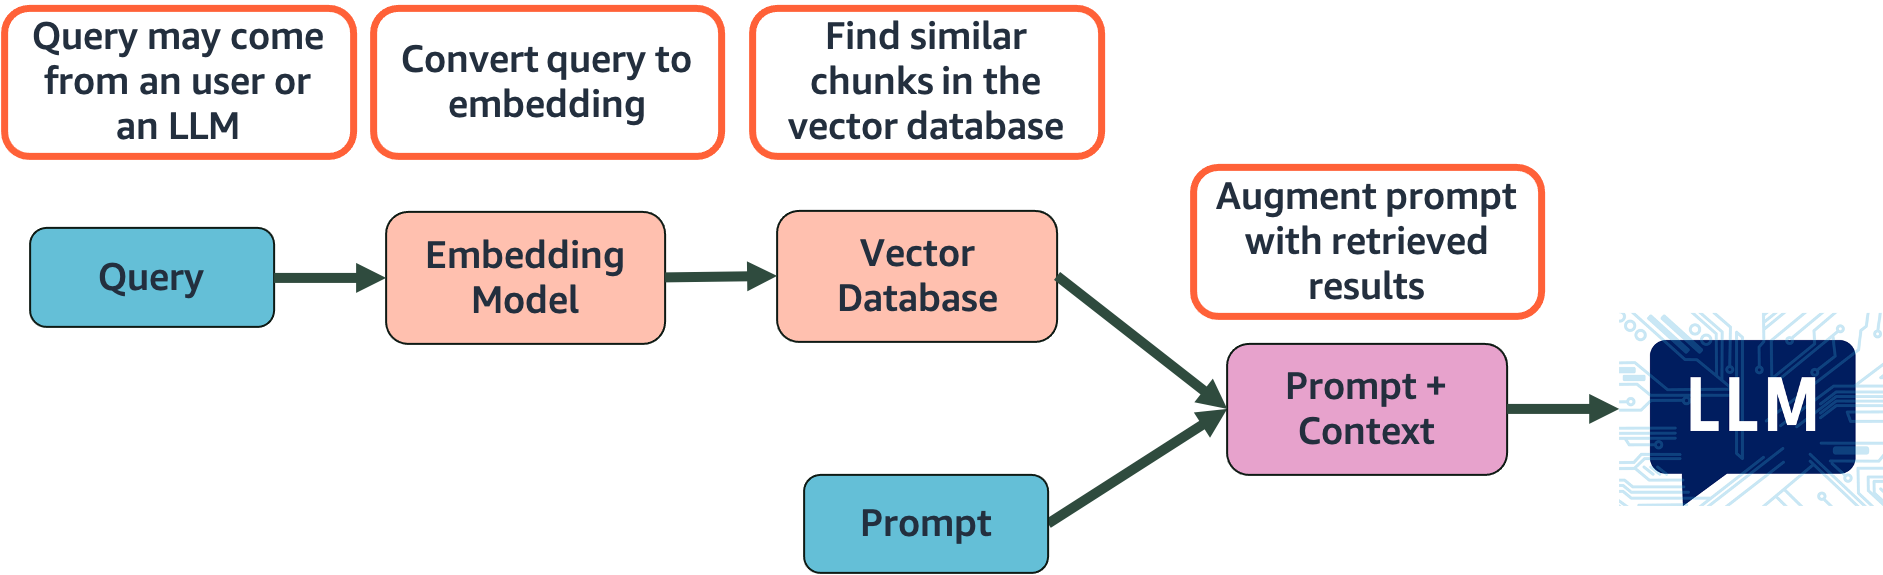
</div>

---

In [12]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

# Supress warnings
warnings.filterwarnings("ignore")

qa_template = """Use the given context to answer the question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible. 

Context: {context}

Question: {question}
Answer:
"""

# Define the prompt template for Q&A
qa_prompt_template = PromptTemplate.from_template(qa_template)

# Define the RetrievalQ&A chain
qa_chain = RetrievalQA.from_chain_type(
    bedrock_llm,
    retriever=vectordb.as_retriever(search_kwargs={"k": 1}),
    return_source_documents=True,
    chain_type="stuff",
    chain_type_kwargs={"prompt": qa_prompt_template},
)

# Perform retrieval Q&A
qa_response = qa_chain({"query": "List some options for using LLMs in AWS?"})

# Format and print in Mardown
Markdown(qa_response["result"])

- Hugging Face
- AI21 Labs
- Cohere
- Anthropic
- OpenAI
- Amazon Titan
- AI21 Labs and Anthropic with APIs
- LangChain retriever interface (AmazonKendraRetriever)
- Other LLMs hosted on an Amazon SageMaker endpoint.

---

Let's compare the retrieval Q&A response against a vanilla LLM response.

In [13]:
# Supress warnings
warnings.filterwarnings("ignore")

llm_template = """ Answer the question below. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Keep the answer as concise as possible.

Question: {question}
Answer:
"""

# Prompt template without context added
llm_prompt_template = PromptTemplate.from_template(llm_template)

# Use the LLM without retriever for response
llm_response = bedrock_llm(
    llm_prompt_template.format(question="What options do I have for using LLMs in AWS?")
)

# Use dataframe to store and print the responses
comparison_df = pd.DataFrame(
    [(qa_response["result"], llm_response)],
    columns=["RAG Response", "Vanilla LLM Response"],
)
with pd.option_context("display.max_colwidth", None):
    display(comparison_df)

,RAG Response,Vanilla LLM Response
0,- Hugging Face\n- AI21 Labs\n- Cohere\n- Anthropic\n- OpenAI\n- Amazon Titan\n- AI21 Labs and Anthropic with APIs\n- LangChain retriever interface (AmazonKendraRetriever)\n- Other LLMs hosted on an Amazon SageMaker endpoint.,"There are several options for using Language Models (LLMs) in Amazon Web Services (AWS):\n\n1. Amazon Comprehend: A natural language processing (NLP) service that uses LLMs to extract insights and meaning from text.\n2. Amazon Transcribe: An automatic speech recognition (ASR) service that uses LLMs to convert speech to text.\n3. Amazon Translate: A neural machine translation service that uses LLMs to translate text between languages.\n4. Amazon Lex: A service for building conversational interfaces using voice and text, which uses LLMs for natural language understanding.\n5. Amazon Polly: A text-to-speech service that uses LLMs to convert text into lifelike speech.\n6. AWS Lambda: A serverless compute service that lets you run your own code, including LLMs, in response to events and automatically manages the underlying compute resources for you.\n\nYou can also use LLMs from other providers, such as TensorFlow and PyTorch, on AWS through services like Amazon SageMaker, which is a fully managed platform that provides every developer and data scientist with the ability to build, train, and deploy machine learning (ML) models quickly."


### <a name="#4">Conversational Q&A</a>
(<a href="#0">Go to top</a>)

Now that we have a functioning retrieval-based Q&A chain, let's extend it for conversational applications. The main addition is the memory module to persist past interactions. 
The `ConversationalRetrievalChain` creates a standalone question for itself upon every follow-up prompt. The standalone question is intended to contain all the relevant context within itself so that the LLM may produce the desired output.

<div>
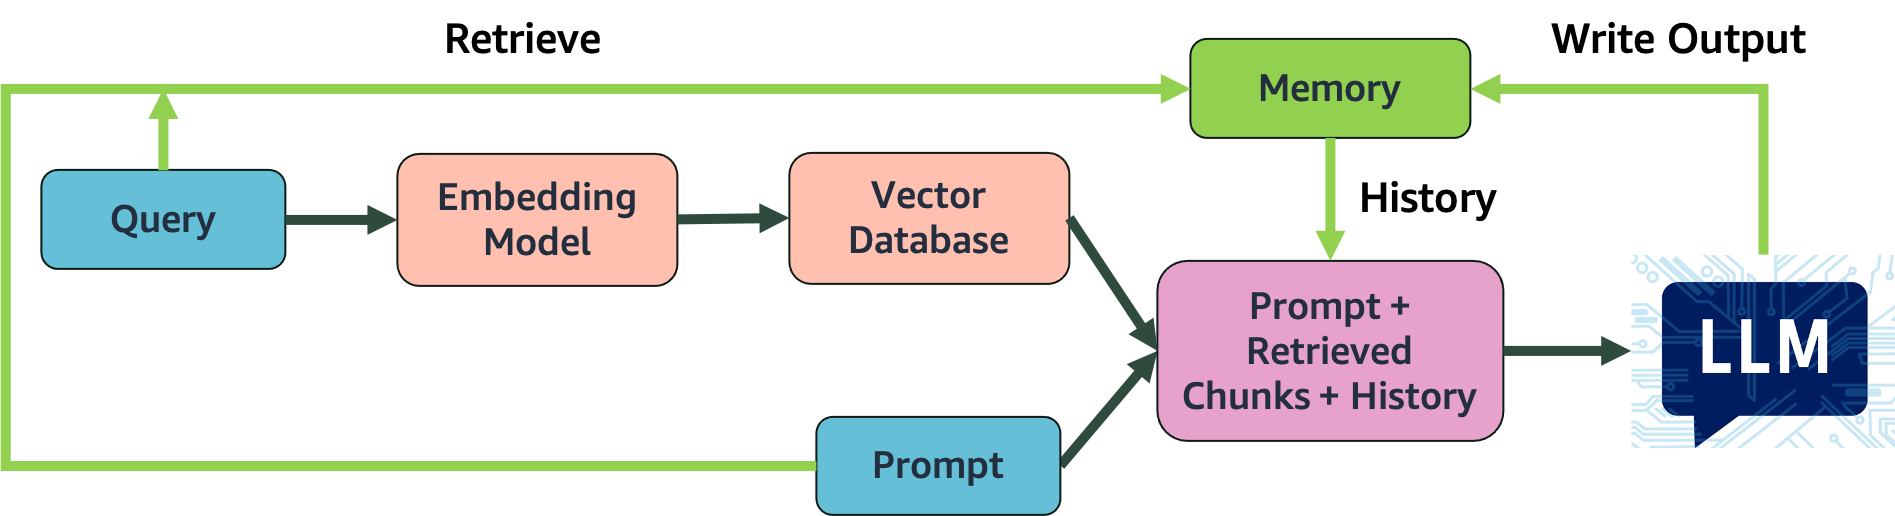
</div>

---

In [14]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

# Let's use the ConversationalBufferMemory to persist interactions with the LLM
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Let's define the conversational Q&A chain to chat over external data.
# We will use the same prompt template from the last section
conversational_qa = ConversationalRetrievalChain.from_llm(
    bedrock_llm,
    retriever=vectordb.as_retriever(search_kwargs={"k": 3}),
    # return_source_documents=True,
    chain_type="stuff",
    memory=memory,
    combine_docs_chain_kwargs={"prompt": qa_prompt_template},
)

In [15]:
# Let's start with the first query for the ConversationalRetrievalChain
first_query = "How can Amazon Kendra be used for developing RAG workflows?"

# Generating the response
first_response = conversational_qa({"question": first_query})

# Format and print the response
Markdown(first_response["answer"])

Amazon Kendra can be used for developing RAG workflows by providing out-of-the-box semantic search capabilities for state-of-the-art ranking of documents and passages. The high-accuracy search in Amazon Kendra can source the most relevant content and documents to maximize the quality of the RAG payload, yielding better LLM responses than using conventional or keyword-based search solutions. Amazon Kendra offers easy-to-use deep learning search models that are pre-trained on 14 domains and don't require any ML expertise. The Retrieve API in Amazon Kendra is designed for the RAG use case and can retrieve up to 100 semantically relevant passages of up to 200 token words each, ordered by relevance. Amazon Kendra also comes with pre-built connectors to popular data sources such as Amazon S3, SharePoint, Confluence, and websites, and supports common document formats such as HTML, Word, PowerPoint, PDF, Excel, and pure text files. To filter responses based on only those documents that the end-user permissions allow, Amazon Kendra offers connectors with access control list (ACL) support. Amazon Kendra also offers AWS Identity and Access Management (IAM) and AWS IAM Identity Center (successor to AWS Single Sign-On) integration for user-group information syncing with customer identity providers such as Okta and Azure AD.

In [16]:
# Continue the conversation with a follow-up question
followup_query = "How does it differ from Amazon Bedrock?"

# Generate the response to the follow-up question
followup_response = conversational_qa(
    {"question": followup_query},
    metadata={
        "do_sample": True,
        "temperature": 0.1,
        "repetition_penalty": 1.6,
        "max_new_tokens": 64,
    },
)

# Format and print the response
Markdown(followup_response["answer"])

Amazon Kendra is a fully managed service that provides out-of-the-box semantic search capabilities for state-of-the-art ranking of documents and passages, while Amazon Bedrock is a managed service that allows users to choose Amazon Titan or partner LLMs with APIs securely without the need for data to leave the AWS ecosystem. Additionally, Amazon Bedrock offers a serverless architecture, a single API to call the supported LLMs, and a managed service to streamline the developer workflow.

#### Notes

Follow-up questions are reformulated into standalone questions in the `ConversationalRetrievalChain` chain. This means there are at least two LLM calls for each follow-up question.

---

### <a name="5">Quizzes</a>
(<a href="#0">Go to top</a>)

Well done on completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding of using pre-trained LLMs for inference.</p>
    <br>
</div>


In [17]:
from mlu_utils.quiz_questions import *

lab3_question1

In [18]:
lab3_question2

<p style="padding: 10px; border: 1px solid black;">
<img src="images/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>

# Thank you!